In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

from face import FACE_KDE, run_face_experiment, get_path_probabilities

In [64]:
try:
    df_dict = pd.read_excel('./data/DataDictionary.xls', header=0)
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o caminho!")

# Visualização elegante
# Filtramos as colunas úteis (geralmente 'Variable Name' e 'Description')
df_dict = df_dict.dropna(how='all').reset_index(drop=True)

# Define que não haverá limite de largura para as colunas
pd.set_option('display.max_colwidth', None)

display(df_dict)

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Variable Name,Description,Type
1,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
2,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
3,age,Age of borrower in years,integer
4,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
5,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer


In [51]:
df_credit = pd.read_csv('./data/GiveMeSomeCredit-training.csv')

In [52]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [53]:
df_credit.dropna(inplace=True)
df_credit = df_credit.drop('Unnamed: 0', axis=1)

df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120269 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      120269 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  120269 non-null  float64
 2   age                                   120269 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  120269 non-null  int64  
 4   DebtRatio                             120269 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       120269 non-null  int64  
 7   NumberOfTimes90DaysLate               120269 non-null  int64  
 8   NumberRealEstateLoansOrLines          120269 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  120269 non-null  int64  
 10  NumberOfDependents                    120269 non-null  float64
dtypes: fl

In [54]:
y = df_credit['SeriousDlqin2yrs']
X = df_credit.drop(columns=['SeriousDlqin2yrs'])

# Split de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização (CRUCIAL para o FACE)
# Guardamos o scaler para inverter a transformação nos contrafatuais depois
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
# Treino do Modelo (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Avaliação
y_pred = model.predict(X_test_scaled)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 0.93

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22383
           1       0.53      0.18      0.27      1671

    accuracy                           0.93     24054
   macro avg       0.74      0.59      0.62     24054
weighted avg       0.91      0.93      0.92     24054



In [56]:
# Criando um DataFrame de análise para o teste
test_results = pd.DataFrame(X_test, columns=X.columns)
test_results['true_label'] = y_test.values
test_results['predicted_label'] = y_pred

# Filtrar instâncias onde o modelo previu risco (1) 
# e queremos transformá-las em (0)
candidates_for_explanation = test_results[test_results['predicted_label'] == 1]

print(f"Total de candidatos para gerar contrafatuais: {len(candidates_for_explanation)}")

Total de candidatos para gerar contrafatuais: 579


In [57]:
clients_at_risk = candidates_for_explanation.drop(columns=['true_label', 'predicted_label'])
clients_at_risk = scaler.transform(clients_at_risk)  # Escalar os dados dos candidatos

### Adicionar restrições

In [58]:
feature_names = X.columns.tolist()
constraints = {}

# --- Ações que melhoram o score ao AUMENTAR ---
increasing_features = [
    'age', 
    'MonthlyIncome'
]

# --- Ações que melhoram o score ao DIMINUIR ---
decreasing_features = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

# --- Variáveis que NÃO devem mudar (Não-acionáveis) ---
fixed_features = [
    'NumberOfDependents'
]

# Mapeando para os índices conforme exigido pela classe FACE_KDE
for f in increasing_features:
    if f in feature_names:
        constraints[feature_names.index(f)] = "increasing"

for f in decreasing_features:
    if f in feature_names:
        constraints[feature_names.index(f)] = "decreasing"

for f in fixed_features:
    if f in feature_names:
        constraints[feature_names.index(f)] = "fixed"

print(f"Dicionário de Restrições Gerado: {constraints}")

Dicionário de Restrições Gerado: {1: 'increasing', 4: 'increasing', 0: 'decreasing', 3: 'decreasing', 2: 'decreasing', 8: 'decreasing', 6: 'decreasing', 9: 'fixed'}


## Experimentos com KDE

--- Análise de Distâncias (k=20) ---
Média: 0.0371
Mediana: 0.0325
Desvio Padrão: 0.0184
Sugestão de Epsilon (Média + 1 DP): 0.0555


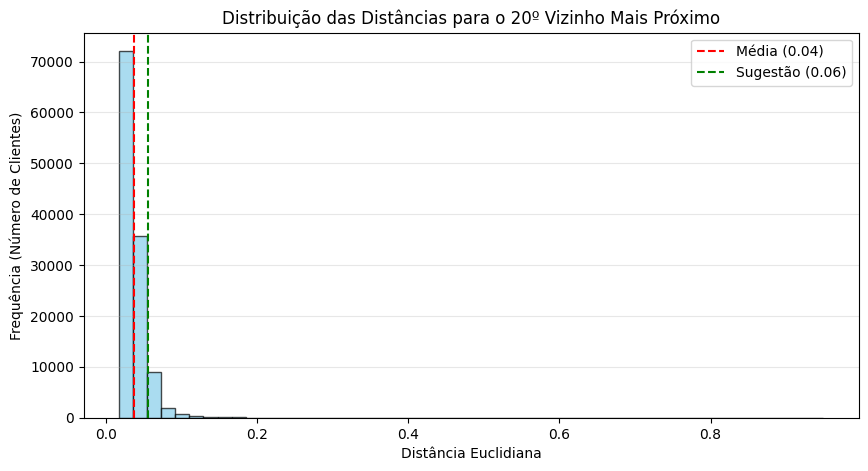

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def analyze_epsilon_threshold(data, k=5):
    """
    Analisa as distâncias para os k vizinhos mais próximos 
    para sugerir um valor de epsilon fundamentado.
    """
    # 1. Calcular as distâncias para os k vizinhos
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(data)
    distances, _ = nn.kneighbors(data)
    
    # Pegamos a distância para o k-ésimo vizinho (geralmente a mais útil para conectividade)
    k_distances = distances[:, -1]
    
    # 2. Estatísticas Descritivas
    mean_dist = np.mean(k_distances)
    median_dist = np.median(k_distances)
    std_dist = np.std(k_distances)
    suggested_eps = mean_dist + std_dist # Uma regra de bolso comum
    
    print(f"--- Análise de Distâncias (k={k}) ---")
    print(f"Média: {mean_dist:.4f}")
    print(f"Mediana: {median_dist:.4f}")
    print(f"Desvio Padrão: {std_dist:.4f}")
    print(f"Sugestão de Epsilon (Média + 1 DP): {suggested_eps:.4f}")
    
    # 3. Visualização (K-Distance Plot)
    plt.figure(figsize=(10, 5))
    plt.hist(k_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(mean_dist, color='red', linestyle='--', label=f'Média ({mean_dist:.2f})')
    plt.axvline(suggested_eps, color='green', linestyle='--', label=f'Sugestão ({suggested_eps:.2f})')
    
    plt.title(f'Distribuição das Distâncias para o {k}º Vizinho Mais Próximo')
    plt.xlabel('Distância Euclidiana')
    plt.ylabel('Frequência (Número de Clientes)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return suggested_eps

recommended_eps = analyze_epsilon_threshold(X_full_scaled, k=20)

In [60]:
def suggest_td_threshold(model, data, labels, kde, target_class=0, percentile=5):
    """
    Sugere um valor para td baseado na densidade dos dados reais aprovados.
    """
    # 1. Filtrar apenas quem é da classe alvo (Aprovados)
    target_data = data[labels == target_class]
    
    # 2. Calcular a densidade desses pontos usando o seu KDE treinado
    log_densities = kde.score_samples(target_data)
    densities = np.exp(log_densities)
    
    # 3. Pegar o percentil escolhido
    suggested_td = np.percentile(densities, percentile)
    
    print(f"Sugestão td (Percentil {percentile}%): {suggested_td:.6f}")
    return suggested_td

In [61]:
# Amostra apenas 15.000 pontos para o grafo, mantendo a proporção das classes
from sklearn.model_selection import train_test_split

X_sample, _, y_sample, _ = train_test_split(
    X_train_scaled, y_train, train_size=15000, stratify=y_train, random_state=42
)

In [62]:
# face_explainer_kde = FACE_KDE(model, X_sample, y_sample, epsilon=0.06)

# suggested_td = suggest_td_threshold(model, X_train_scaled, y_train, face_explainer_kde.kde, target_class=0, percentile=5)

KeyboardInterrupt: 

In [65]:
face_explainer_kde = FACE_KDE(model, X_sample, y_sample, epsilon=0.06)

df_steps, path_scaled = run_face_experiment(face_explainer_kde, clients_at_risk, scaler, X.columns, instance_idx=0)

KeyboardInterrupt: 

In [ ]:
for i in range(len(clients_at_risk)):
    res, path = run_face_experiment(face_explainer_kde, clients_at_risk, scaler, X.columns, instance_idx=i)
    if path is not None and len(path) > 1:
        print(f"Sucesso encontrado no índice {i}!")
        break

--- Experimento com Instância Index 0 ---
Sucesso! Caminho encontrado com 2 passos.
                                    Diferença (Δ)
months_since_first_trade                     58.0
months_since_last_trade                       1.0
average_duration_of_resolution               -1.0
number_of_satisfactory_trades                 8.0
percentage_of_legal_trades                    8.0
months_since_last_illegal_trade               4.0
nr_total_trades                               3.0
percentage_of_installment_trades            -37.0
net_fraction_of_revolving_burden            -17.0
net_fraction_of_installment_burden          -34.0
nr_installment_trades_with_balance           -1.0
nr_banks_with_high_ratio                     -2.0
percentage_trades_with_balance              -25.0
Sucesso encontrado no índice 0!


In [ ]:
# 1. Verifique se existem alvos candidatos (ICT)
probs = model.predict_proba(X_full_scaled)[:, 0] # Probabilidade de Aprovado
densities = np.exp(face_explainer_kde.kde.score_samples(X_full_scaled))

tp = 0.5
td = suggested_td # O valor de bilhões que calculamos

ict_indices = np.where((probs >= tp) & (densities >= td))[0]
print(f"Candidatos a alvo (ICT): {len(ict_indices)} pontos encontrados de {len(X_full_scaled)}")

# 2. Verifique se a sua Query consegue se conectar a ALGUÉM
query = clients_at_risk[1].reshape(1, -1)
nn = NearestNeighbors(radius=face_explainer_kde.epsilon)
nn.fit(face_explainer_kde.valid_data)
dists, idxs = nn.radius_neighbors(query)

print(f"Vizinhos dentro do epsilon (0.6): {len(idxs[0])}")

# 3. Verifique quantos desses vizinhos respeitam as restrições
valid_connections = 0
if len(idxs[0]) > 0:
    for idx in idxs[0]:
        if face_explainer_kde._check_constraints(query.flatten(), face_explainer_kde.valid_data[idx]):
            valid_connections += 1
print(f"Conexões iniciais válidas (respeitando restrições): {valid_connections}")

Candidatos a alvo (ICT): 853 pontos encontrados de 2502
Vizinhos dentro do epsilon (0.6): 4
Conexões iniciais válidas (respeitando restrições): 1
